In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [6]:
model = load_model("GOAT.h5") # modello
_, h, w, _ = model.input_shape

# mapping numeri-classi
class_names = [
    "Erlang/Rayleigh",
    "Gaussian",
    "Original",
    "Periodic",
    "Salt & Pepper",
    "Speckle",
    "Striping Horizontal",
    "Striping Vertical",
    "Uniform"
]

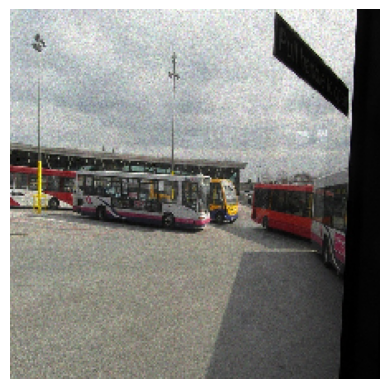

In [17]:
# 2) Percorso immagine utente
image_path = "impossible.jpg"

# 3) Caricamento e preprocessing esattamente come in training
#    load_img usa per default interpolation='nearest', proprio come flow_from_dataframe
img = load_img(image_path, target_size=(H, W))  
arr = img_to_array(img)            # array float32 shape (H, W, 3)
arr /= 255.0                       # rescale [0,1]
arr = np.expand_dims(arr, axis=0)  # batch dimension → (1, H, W, 3)

# 4) (opzionale) Mostro l’immagine preprocessata
plt.imshow(arr[0])
plt.axis('off')
plt.show()


In [18]:
# 5) Inferenza
probs = model.predict(arr).flatten()
top3_idx = np.argsort(probs)[-3:][::-1]

print("Top 3 predizioni con confidenza:")
for rank, idx in enumerate(top3_idx, start=1):
    print(f"{rank}. {class_names[idx]} → {probs[idx]:.4f}")

1/1 [==============================] - 0s 15ms/step
Top 3 predizioni con confidenza:
1. Speckle → 1.0000
2. Original → 0.0000
3. Uniform → 0.0000
